#Image Similarity using **Siamese Network** with a Contrastive Loss

**Author**: [Sayan Nath](https://twitter.com/sayannath2350) <br>
**Date Created**: 2021/06/10 <br>
**Last Updated**: 2021/06/10 <br>

<center><a href="https://colab.research.google.com/drive/17Mib0VpJmf3iL2kg84LHO2_NT1WhF5Lt?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a></center>

## Initial-Setup

In [1]:
!nvidia-smi

Wed Jun  9 22:55:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import the Packages

In [19]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.datasets import fashion_mnist

from tensorflow.keras import backend as K

## Data Gathering

In [5]:
# Load the Dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [6]:
# Prepare Train and Test sets
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# Normalize Images
train_images = train_images / 255.0
test_images = test_images / 255.0

## Create the Pairs

In [7]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):
    
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    
    return pairs, y


def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [8]:
# Create Pairs on Train and Test sets
train_pairs, train_y = create_pairs_on_set(train_images, train_labels)
test_pairs, test_y = create_pairs_on_set(test_images, test_labels)

## Visualise the Images

In [13]:
def visiualise_image(this_pair):
    show_image(test_pairs[this_pair][0])
    show_image(test_pairs[this_pair][1])
    print(test_y[this_pair]) #Label

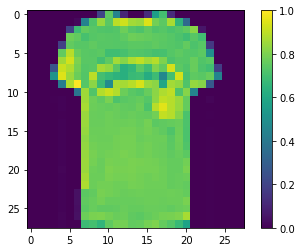

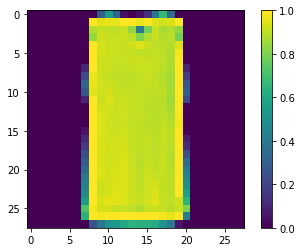

1.0


In [14]:
visiualise_image(0)

Similar

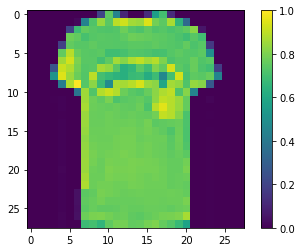

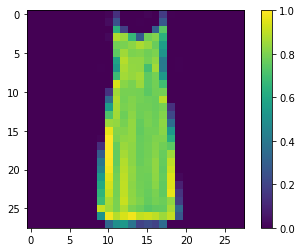

0.0


In [15]:
visiualise_image(1)

Not Similar

## Build the Model

In [16]:
def initialize_base_network():
    input = Input(shape=(28,28,), name="base_input")
    x = Flatten(name="flatten_input")(input)
    x = Dense(128, activation='relu', name="first_base_dense")(x)
    x = Dropout(0.1, name="first_dropout")(x)
    x = Dense(128, activation='relu', name="second_base_dense")(x)
    x = Dropout(0.1, name="second_dropout")(x)
    x = Dense(128, activation='relu', name="third_base_dense")(x)

    return Model(inputs=input, outputs=x)

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

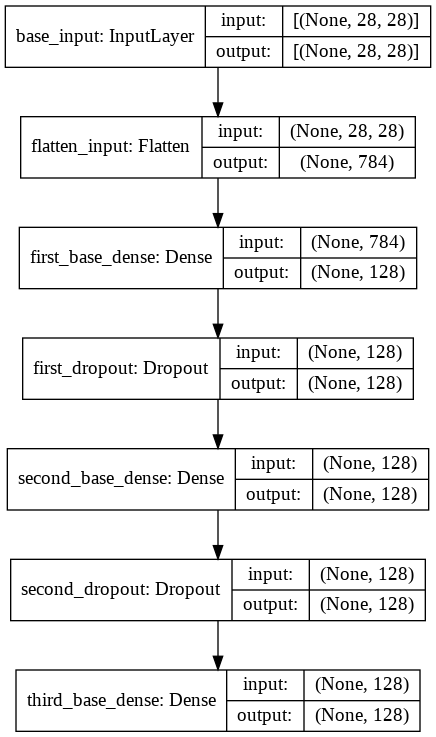

In [17]:
base_network = initialize_base_network()
plot_model(base_network, show_shapes=True, show_layer_names=True, to_file='base-model.png')

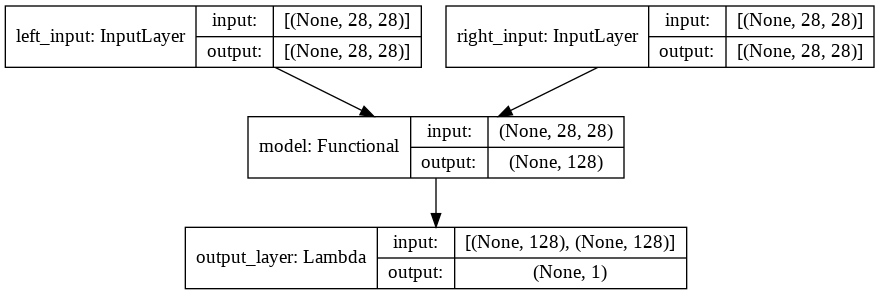

In [20]:
# Left Input
input_a = Input(shape=(28,28,), name="left_input")
vect_output_a = base_network(input_a)

# Right Input
input_b = Input(shape=(28,28,), name="right_input")
vect_output_b = base_network(input_b)

# Calculating the similarity 
output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

model = Model([input_a, input_b], output)

# Plot the Model Graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='outer-model.png')

## Define the Custom Loss Function `contrastive_loss_with_margin`



In [21]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

## Compile the Model

In [22]:
rms = RMSprop()
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)

In [23]:
h = model.fit([train_pairs[:,0], train_pairs[:,1]], train_y, epochs=10, batch_size=128, validation_data=([test_pairs[:,0], test_pairs[:,1]], test_y))

Epoch 1/10
938/938 [==============================] - 7s 4ms/step - loss: 0.1099 - val_loss: 0.0856
Epoch 2/10
938/938 [==============================] - 3s 4ms/step - loss: 0.0803 - val_loss: 0.0838
Epoch 3/10
938/938 [==============================] - 3s 4ms/step - loss: 0.0726 - val_loss: 0.0710
Epoch 4/10
938/938 [==============================] - 3s 4ms/step - loss: 0.0680 - val_loss: 0.0700
Epoch 5/10
938/938 [==============================] - 3s 4ms/step - loss: 0.0646 - val_loss: 0.0713
Epoch 6/10
938/938 [==============================] - 3s 4ms/step - loss: 0.0621 - val_loss: 0.0644
Epoch 7/10
938/938 [==============================] - 3s 4ms/step - loss: 0.0602 - val_loss: 0.0655
Epoch 8/10
938/938 [==============================] - 3s 4ms/step - loss: 0.0589 - val_loss: 0.0631
Epoch 9/10
938/938 [==============================] - 3s 4ms/step - loss: 0.0576 - val_loss: 0.0638
Epoch 10/10
938/938 [==============================] - 3s 4ms/step - loss: 0.0566 - val_loss: 0.0623

## Evaluate the Model

In [24]:
def compute_accuracy(y_true, y_pred):
    pred = y_pred.ravel() < 0.5 #Threshold
    return np.mean(pred == y_true)

In [25]:
loss = model.evaluate(x=[test_pairs[:,0],test_pairs[:,1]], y=test_y)

y_pred_train = model.predict([train_pairs[:,0], train_pairs[:,1]])
train_accuracy = compute_accuracy(train_y, y_pred_train)

y_pred_test = model.predict([test_pairs[:,0], test_pairs[:,1]])
test_accuracy = compute_accuracy(test_y, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

625/625 [==============================] - 1s 2ms/step - loss: 0.0623
Loss = 0.062310367822647095, Train Accuracy = 0.934089014835806 Test Accuracy = 0.915015015015015


## Plot the Metrics

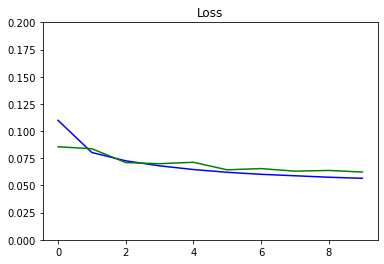

In [27]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(h.history[metric_name],color='blue',label=metric_name)
    plt.plot(h.history['val_' + metric_name],color='green',label='val_' + metric_name)

plot_metrics(metric_name='loss', title="Loss", ylim=0.2)

In [28]:
# Matplotlib config
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts


# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)

## Ramdomly Picked 10 images

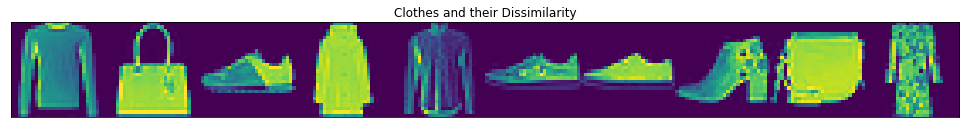

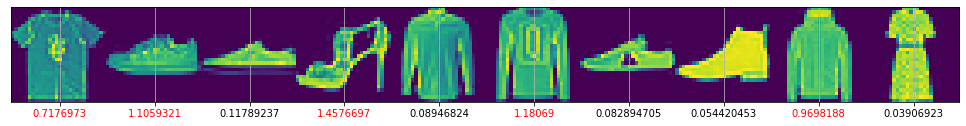

In [30]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(train_pairs[:, 0][indexes], train_pairs[:, 1][indexes], y_pred_train[indexes], train_y[indexes], "Clothes and their Dissimilarity", 10)

Note: More the distance, more the Dissimilarity. Less the distance, less similarity.

# Done